# Bayesian Full-Field Inference

The ultimate goal of differentiable forward modeling is **inference**: given an observed convergence map, what are the initial conditions and cosmological parameters that produced it?

This notebook uses the probabilistic modeling layer to:
1. Define the forward model as a NumPyro probabilistic model
2. Generate mock observations
3. Sample the posterior using MCMC (via `batched_sampling`)
4. Analyze posterior samples

The full-field approach jointly infers the 3D initial conditions field and cosmological parameters, using the differentiable pipeline (IC -> LPT -> PM -> lensing) as the likelihood.

## Setup

In [1]:
import os

os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '0.97'

import jax
import jax.numpy as jnp
import jax_cosmo as jc
import matplotlib.pyplot as plt
import numpyro.distributions as dist

import fwd_model_tools as ffi

/home/wassim/micromamba/envs/ffi11/lib/python3.11/site-packages/jax_cosmo/__init__.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


/home/wassim/micromamba/envs/ffi11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ERROR:2026-02-10 16:24:06,836:jax._src.xla_bridge:491: Jax plugin configuration error: Exception when calling jax_plugins.xla_cuda12.initialize()
Traceback (most recent call last):
  File "/home/wassim/micromamba/envs/ffi11/lib/python3.11/site-packages/jax/_src/xla_bridge.py", line 489, in discover_pjrt_plugins
    plugin_module.initialize()
  File "/home/wassim/micromamba/envs/ffi11/lib/python3.11/site-packages/jax_plugins/xla_cuda12/__init__.py", line 328, in initialize
    _check_cuda_versions(raise_on_first_error=True)
  File "/home/wassim/micromamba/envs/ffi11/lib/python3.11/site-packages/jax_plugins/xla_cuda12/__init__.py", line 285, in _check_cuda_versions
    local_device_count = cuda_versions.cuda_device_count()
                         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: jaxlib/cuda/versions_helpers.cc:113: operation cuInit(0) failed: CUDA_ERROR_UNKNOWN


## Define Configuration

The `Configurations` dataclass bundles all settings for the forward model and inference:
- Source redshift distributions (`nz_shear`)
- Integration parameters (`t0`, `t1`, `dt0`)
- Cosmological priors
- Lensing method and geometry

In [2]:
# Source redshift distributions
nz_sources = [
    ffi.tophat_z(0.0, 0.5, gals_per_arcmin2=5.0),
    ffi.tophat_z(0.5, 1.0, gals_per_arcmin2=5.0),
]

# TODO(human): Define the cosmological priors
# Choose prior distributions for the cosmological parameters you want to infer.
# The priors dict maps parameter names to numpyro distributions.
#
# Available parameters (from jc.Cosmology):
#   - Omega_c: cold dark matter density (Planck18: 0.2607)
#   - Omega_b: baryon density (Planck18: 0.0490)
#   - sigma8: amplitude of fluctuations (Planck18: 0.8102)
#   - h: Hubble parameter (Planck18: 0.6766)
#   - n_s: spectral index (Planck18: 0.9665)
#   - w0: dark energy equation of state (Planck18: -1.0)
#
# Consider:
#   - Which parameters are well-constrained by lensing? (sigma8, Omega_c)
#   - Which should be fixed vs sampled?
#   - What distribution shapes make sense? (Uniform, Normal, TruncatedNormal)
#   - How wide should the priors be?
#
# Example: {"sigma8": dist.Normal(0.8, 0.1), "Omega_c": dist.Uniform(0.1, 0.4)}

priors = {}  # Replace with your prior specification

In [3]:
config = ffi.probabilistic_models.Configurations(
    density_plane_smoothing=0.0,
    nz_shear=nz_sources,
    fiducial_cosmology=ffi.Planck18,
    sigma_e=0.26,
    priors=priors,
    t0=0.1,
    dt0=0.1,
    t1=1.0,
    geometry="spherical",
    lensing="born",
    number_of_shells=4,
    lpt_order=1,
)

## Create Template Field

The template field provides the metadata (mesh size, box size, observer position, resolution) for the forward model. Its actual array values are not used -- only the shape and geometry matter.

In [4]:
key = jax.random.PRNGKey(42)
mesh_size = (32, 32, 32)
box_size = (250.0, 250.0, 250.0)
nside = 32
cosmo = ffi.Planck18()

template_field = ffi.gaussian_initial_conditions(
    key, mesh_size, box_size,
    cosmo=cosmo,
    nside=nside,
)

print(f"Template mesh: {template_field.mesh_size}")
print(f"Template box: {template_field.box_size}")

Template mesh: (32, 32, 32)
Template box: (250.0, 250.0, 250.0)


## Build and Test the Forward Model

`make_full_field_model` returns a JIT-compiled function that maps (cosmology, initial_conditions) to (kappa_maps, lightcone, linear_field). We test it with the fiducial cosmology to generate mock data.

len of nz_shear: 2


Mock kappa shape: (2, 12288)
Mock lightcone shape: (4, 12288)


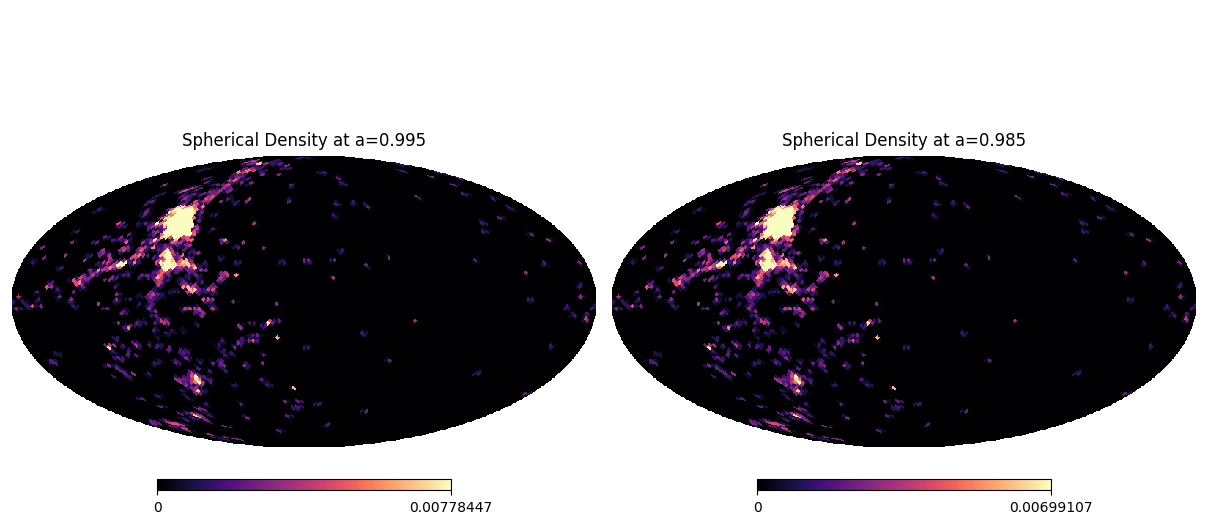

In [5]:
forward_model = ffi.probabilistic_models.make_full_field_model(template_field, config=config)

# Generate mock observation
mock_ic = jax.random.normal(key, shape=mesh_size)
kappa_mock, lightcone_mock, lin_field = forward_model(cosmo, mock_ic)

print(f"Mock kappa shape: {kappa_mock.shape}")
print(f"Mock lightcone shape: {lightcone_mock.shape}")
kappa_mock.show()

## Build Probabilistic Model

`full_field_probmodel` wraps the forward model in a NumPyro model that:
1. Samples cosmological parameters from the priors
2. Samples the initial conditions from a standard normal
3. Runs the forward model
4. Adds Gaussian noise based on `sigma_e` and galaxy density

In [6]:
prob_model = ffi.probabilistic_models.full_field_probmodel(template_field, config)

## Sampling with batched_sampling

`batched_sampling` runs MCMC in checkpointed batches. Each batch is saved to disk, allowing long runs to be resumed. It supports:
- **Backend**: `"numpyro"` (pure NumPyro) or `"blackjax"` (BlackJAX kernels via NumPyro)
- **Sampler**: `"NUTS"` or `"HMC"` (numpyro), or `"MCLMC"` (blackjax only)
- **Batching**: `batch_count` controls how many batches to run sequentially

For this demo we use a very small number of samples.

In [7]:
output_path = "output/demo_inference"
sample_key = jax.random.PRNGKey(0)

# Small demo run
ffi.sampling.batched_sampling(
    prob_model,
    path=output_path,
    rng_key=sample_key,
    num_warmup=10,
    num_samples=20,
    batch_count=1,
    sampler="NUTS",
    backend="numpyro",
    progress_bar=True,
)

len of nz_shear: 2


Number of kappa fields: (2, 12288) number of nz_shear: 2


Number of kappa fields: (2, 12288) number of nz_shear: 2


  0%|          | 0/10 [00:00<?, ?it/s]

Number of kappa fields: (2, 12288) number of nz_shear: 2


warmup:  10%|█         | 1/10 [00:11<01:47, 11.92s/it, 1 steps of size 2.34e+00. acc. prob=0.00]

warmup:  20%|██        | 2/10 [00:13<00:44,  5.59s/it, 1 steps of size 2.30e-01. acc. prob=0.00]

warmup:  30%|███       | 3/10 [00:14<00:25,  3.63s/it, 1 steps of size 1.67e-02. acc. prob=0.00]

warmup:  40%|████      | 4/10 [00:15<00:15,  2.65s/it, 1 steps of size 1.07e-03. acc. prob=0.00]

warmup:  50%|█████     | 5/10 [00:16<00:10,  2.09s/it, 1 steps of size 1.30e-03. acc. prob=0.20]

warmup:  60%|██████    | 6/10 [00:19<00:09,  2.44s/it, 3 steps of size 1.89e-03. acc. prob=0.33]

warmup:  70%|███████   | 7/10 [00:22<00:08,  2.71s/it, 3 steps of size 1.08e-03. acc. prob=0.38]

warmup:  80%|████████  | 8/10 [00:25<00:05,  2.52s/it, 2 steps of size 3.86e-04. acc. prob=0.40]

warmup:  90%|█████████ | 9/10 [00:26<00:02,  2.06s/it, 1 steps of size 2.94e-05. acc. prob=0.35]

warmup: 100%|██████████| 10/10 [00:30<00:00,  2.68s/it, 4 steps of size 5.52e-04. acc. prob=0.39]

warmup: 100%|██████████| 10/10 [00:30<00:00,  3.02s/it, 4 steps of size 5.52e-04. acc. prob=0.39]

Sampling batch 1/1 using NUTS with numpyro...
At sample batch 1, total samples so far: 0
Number of kappa fields: (2, 12288) number of nz_shear: 2
Number of kappa fields: (2, 12288) number of nz_shear: 2


  0%|          | 0/20 [00:00<?, ?it/s]

Number of kappa fields: (2, 12288) number of nz_shear: 2


sample:   5%|▌         | 1/20 [00:12<04:00, 12.68s/it, 1 steps of size 5.52e-04. acc. prob=0.36]

sample:  10%|█         | 2/20 [00:13<01:44,  5.83s/it, 1 steps of size 5.52e-04. acc. prob=0.33]

sample:  15%|█▌        | 3/20 [00:14<01:02,  3.69s/it, 1 steps of size 5.52e-04. acc. prob=0.30]

sample:  20%|██        | 4/20 [00:15<00:42,  2.67s/it, 1 steps of size 5.52e-04. acc. prob=0.28]

sample:  25%|██▌       | 5/20 [00:17<00:31,  2.12s/it, 1 steps of size 5.52e-04. acc. prob=0.26]

sample:  30%|███       | 6/20 [00:18<00:24,  1.76s/it, 1 steps of size 5.52e-04. acc. prob=0.24]

sample:  35%|███▌      | 7/20 [00:19<00:20,  1.55s/it, 1 steps of size 5.52e-04. acc. prob=0.23]

sample:  40%|████      | 8/20 [00:20<00:16,  1.41s/it, 1 steps of size 5.52e-04. acc. prob=0.22]

sample:  45%|████▌     | 9/20 [00:21<00:14,  1.31s/it, 1 steps of size 5.52e-04. acc. prob=0.21]

sample:  50%|█████     | 10/20 [00:22<00:12,  1.26s/it, 1 steps of size 5.52e-04. acc. prob=0.20]

sample:  55%|█████▌    | 11/20 [00:23<00:10,  1.17s/it, 1 steps of size 5.52e-04. acc. prob=0.19]

sample:  60%|██████    | 12/20 [00:24<00:09,  1.14s/it, 1 steps of size 5.52e-04. acc. prob=0.18]

sample:  65%|██████▌   | 13/20 [00:25<00:07,  1.11s/it, 1 steps of size 5.52e-04. acc. prob=0.17]

sample:  70%|███████   | 14/20 [00:26<00:06,  1.10s/it, 1 steps of size 5.52e-04. acc. prob=0.16]

sample:  75%|███████▌  | 15/20 [00:27<00:05,  1.10s/it, 1 steps of size 5.52e-04. acc. prob=0.16]

sample:  80%|████████  | 16/20 [00:29<00:04,  1.11s/it, 1 steps of size 5.52e-04. acc. prob=0.15]

sample:  85%|████████▌ | 17/20 [00:30<00:03,  1.08s/it, 1 steps of size 5.52e-04. acc. prob=0.15]

sample:  90%|█████████ | 18/20 [00:31<00:02,  1.08s/it, 1 steps of size 5.52e-04. acc. prob=0.14]

sample:  95%|█████████▌| 19/20 [00:32<00:01,  1.10s/it, 1 steps of size 5.52e-04. acc. prob=0.14]

sample: 100%|██████████| 20/20 [00:33<00:00,  1.12s/it, 1 steps of size 5.52e-04. acc. prob=0.13]

sample: 100%|██████████| 20/20 [00:33<00:00,  1.67s/it, 1 steps of size 5.52e-04. acc. prob=0.13]

Saving batch 1 samples and state...


## Load and Inspect Samples

In [8]:
samples = ffi.sampling.load_samples(output_path)

print("Posterior sample keys:")
for k, v in samples.items():
    if hasattr(v, 'shape'):
        print(f"  {k}: shape={v.shape}")
    else:
        print(f"  {k}: {type(v)}")

Loading 1 sample batch(es) from output/demo_inference
  Loading batch 1/1: samples_0
Loaded 4 parameter(s): ['num_steps', 'kappa_1', 'initial_conditions', 'kappa_0']
Total samples: 20
Posterior sample keys:
  num_steps: shape=(20,)
  kappa_1: shape=(20, 12288)
  initial_conditions: shape=(20, 32, 32, 32)
  kappa_0: shape=(20, 12288)


/home/wassim/micromamba/envs/ffi11/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/jax_array_handlers.py:711: UserWarning: Sharding info not provided when restoring. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


## Posterior Predictive Power Spectra

Run the forward model on posterior samples to see how well the inferred parameters and initial conditions reproduce the observed data.

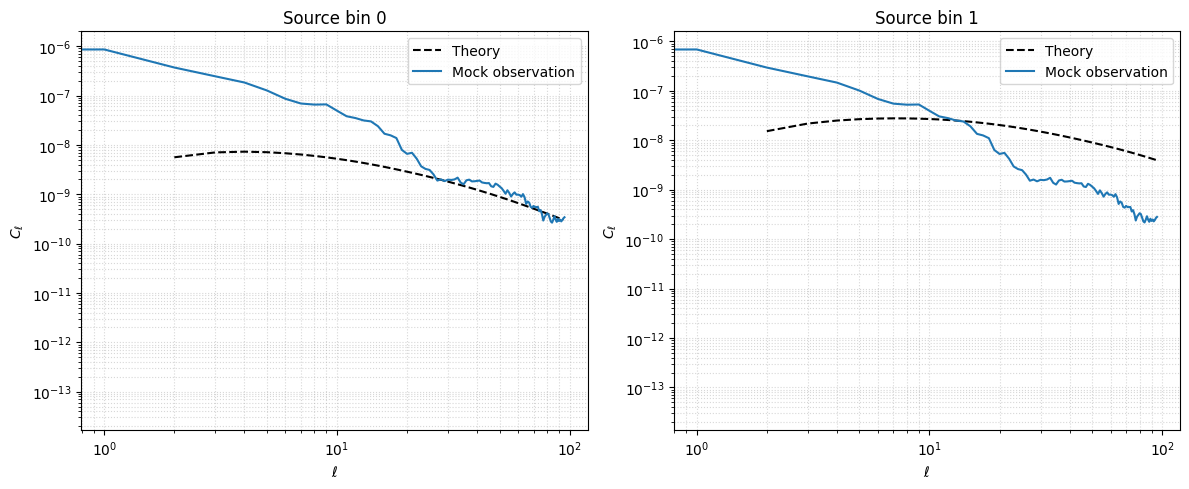

In [9]:
# Compare mock observation power spectrum against theory
LMAX = 3 * nside - 1
ells = jnp.arange(2, LMAX)

theory_cl = ffi.compute_theory_cl(
    cosmo, ell=ells, z_source=nz_sources,
    probe_type="weak_lensing", nonlinear_fn="linear", cross=False,
)

cl_mock = kappa_mock.angular_cl(method="healpy")

n_sources = len(nz_sources)
fig, axes = plt.subplots(1, n_sources, figsize=(6 * n_sources, 5))
if n_sources == 1:
    axes = [axes]

for i in range(n_sources):
    theory_cl[i].plot(ax=axes[i], logx=True, logy=True, label=["Theory"], color="black", linestyle="--")
    cl_mock[i].plot(ax=axes[i], logx=True, logy=True, label=["Mock observation"], color="tab:blue")
    axes[i].set_title(f"Source bin {i}")
    axes[i].legend()

plt.tight_layout()
plt.show()